<a href="https://colab.research.google.com/github/Hoopoe11/Lab/blob/main/zad_dom_lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)



60000 train samples
10000 test samples


In [6]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [7]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  width_shift_range=trial.suggest_uniform('width_shift_range', .00,0.20)
  height_shift_range=trial.suggest_uniform(' height_shift_range', .00,0.20)
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    zoom_range=zoom_range
    )

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  from keras.callbacks import EarlyStopping
  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  early_stoping=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), callbacks=[early_stoping])

  results = model.evaluate(x_test, y_test,verbose=0)
  return results[1]

In [8]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=30,timeout=1200)

[I 2020-12-21 12:11:34,382] A new study created in memory with name: no-name-858aeda6-3733-46b9-94fb-ca5bb066b611
[I 2020-12-21 12:12:01,386] Trial 0 finished with value: 0.9656999707221985 and parameters: {'rotation_range': 11.192195143804511, 'zoom_range': 0.07783943375422385, 'width_shift_range': 0.10276717391661594, ' height_shift_range': 0.17638384366428844}. Best is trial 0 with value: 0.9656999707221985.
[I 2020-12-21 12:12:28,142] Trial 1 finished with value: 0.9700999855995178 and parameters: {'rotation_range': 8.477167028781162, 'zoom_range': 0.22431327194704678, 'width_shift_range': 0.09554678143264494, ' height_shift_range': 0.11274759915359266}. Best is trial 1 with value: 0.9700999855995178.
[I 2020-12-21 12:12:55,094] Trial 2 finished with value: 0.97079998254776 and parameters: {'rotation_range': 1.2231766077029338, 'zoom_range': 0.16510137997571336, 'width_shift_range': 0.19780550397413102, ' height_shift_range': 0.13336459982443696}. Best is trial 2 with value: 0.9707

In [9]:
print("Liczba końcowa trials: {}".format(len(study.trials)))

print("Najlepszy trial:")
trial=study.best_trial

print("Wartosc: {}".format(trial.value))

print("Paramery")
for key, value in trial.params.items():
  print("  {}:{}".format(key, value))

Liczba końcowa trials: 30
Najlepszy trial:
Wartosc: 0.9785000085830688
Paramery
  rotation_range:18.660128611065403
  zoom_range:0.2472482989809963
  width_shift_range:0.07898820189883111
   height_shift_range:0.1128312673015872


In [10]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
width_shift_range=trial.params.get('width_shift_range')
height_shift_range=trial.params.get('height_shift_range')
  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    zoom_range=zoom_range
    )

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

from keras.callbacks import EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
early_stoping=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test), callbacks=[early_stoping]) 


Epoch 1/50
8/8 [==============================] - 1s 96ms/step - loss: 2.2923 - accuracy: 0.1298 - val_loss: 2.1887 - val_accuracy: 0.4464
Epoch 2/50
8/8 [==============================] - 1s 69ms/step - loss: 2.1563 - accuracy: 0.2492 - val_loss: 1.4308 - val_accuracy: 0.6238
Epoch 3/50
8/8 [==============================] - 1s 70ms/step - loss: 1.7488 - accuracy: 0.4021 - val_loss: 0.9106 - val_accuracy: 0.7277
Epoch 4/50
8/8 [==============================] - 1s 71ms/step - loss: 1.2765 - accuracy: 0.5646 - val_loss: 0.6311 - val_accuracy: 0.7945
Epoch 5/50
8/8 [==============================] - 1s 70ms/step - loss: 1.0794 - accuracy: 0.6404 - val_loss: 0.4932 - val_accuracy: 0.8554
Epoch 6/50
8/8 [==============================] - 1s 74ms/step - loss: 1.0174 - accuracy: 0.6801 - val_loss: 0.4174 - val_accuracy: 0.8756
Epoch 7/50
8/8 [==============================] - 1s 70ms/step - loss: 0.7786 - accuracy: 0.7560 - val_loss: 0.3171 - val_accuracy: 0.9031
Epoch 8/50
8/8 [===========

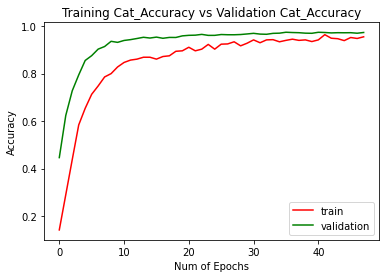

In [11]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])
 

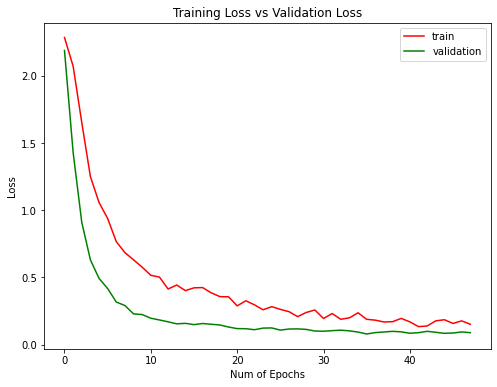

In [12]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


(1000, 28, 28)


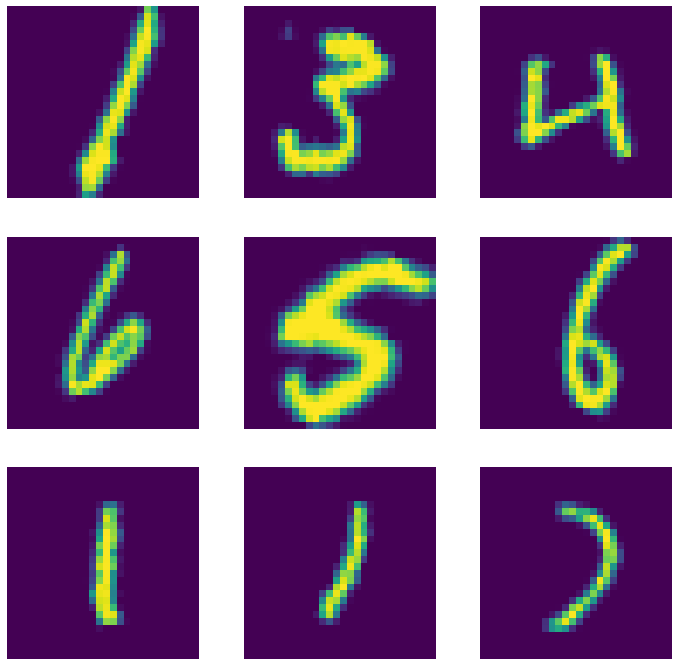

In [13]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

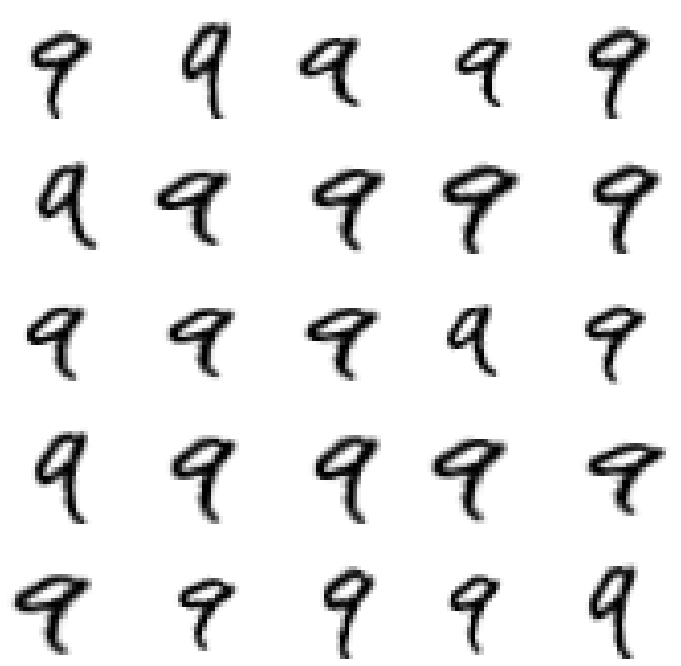

In [14]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

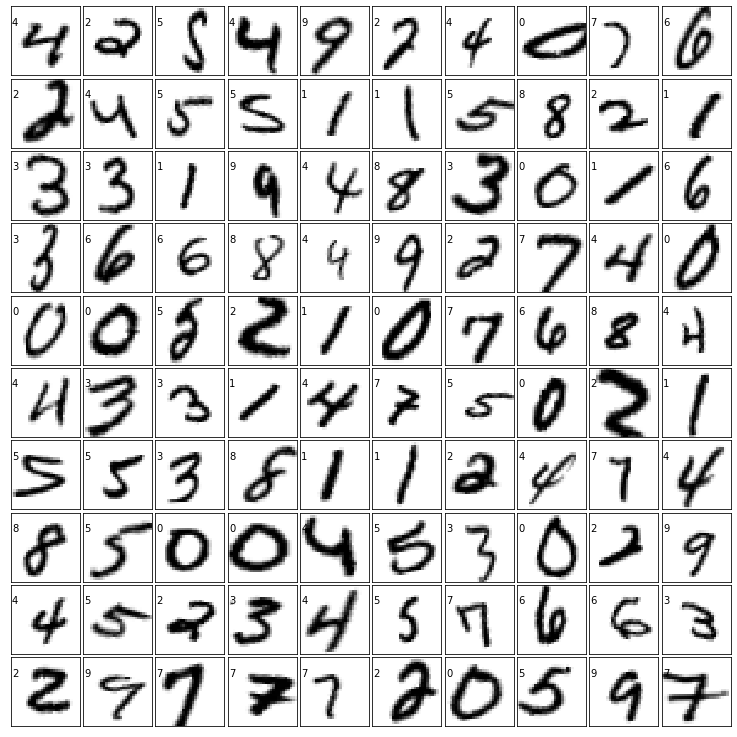

In [15]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

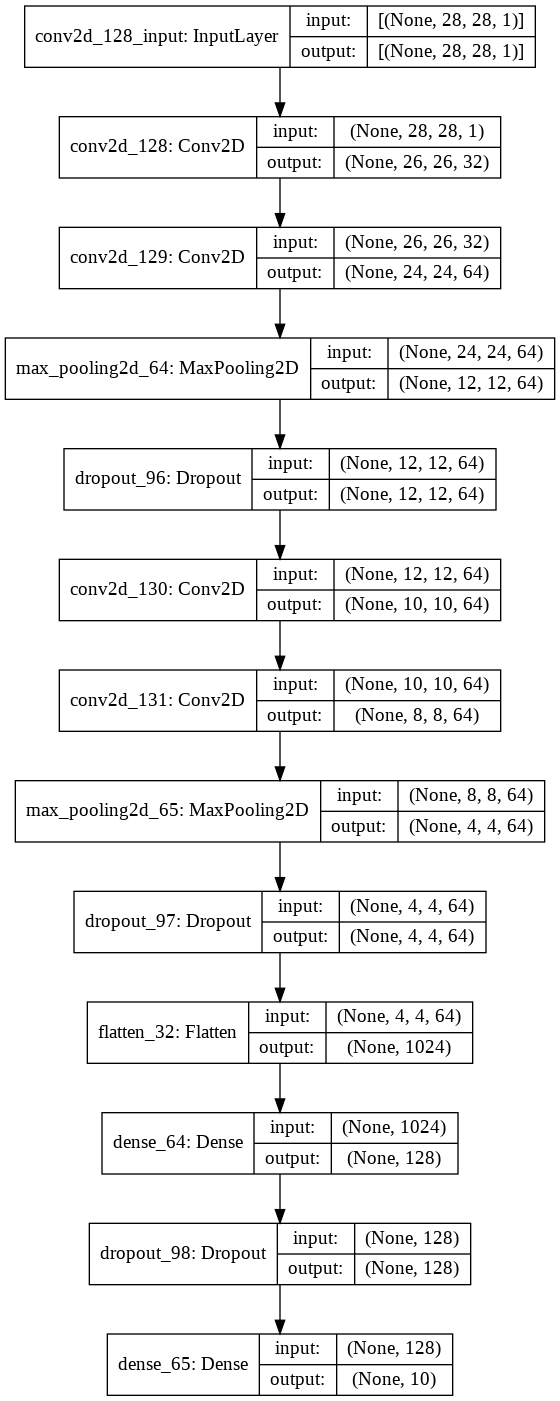

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [17]:

# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.20% , Test: 97.32% 


In [18]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 0s
[[ 975    0    0    0    0    0    3    1    1    0]
 [   0 1120    5    0    0    1    2    4    3    0]
 [   3    0 1019    0    1    0    1    6    2    0]
 [   2    0    9  968    0   10    0    7   13    1]
 [   1    1    1    0  951    0    6    0    0   22]
 [   3    2    1    6    0  858    6    1   12    3]
 [   8    3    0    0    1    0  945    0    1    0]
 [   1    1   24    5    1    0    0  983    2   11]
 [  11    1    4    0    3    1    2    0  936   16]
 [   6    1    0    1    9    4    1    4    6  977]]


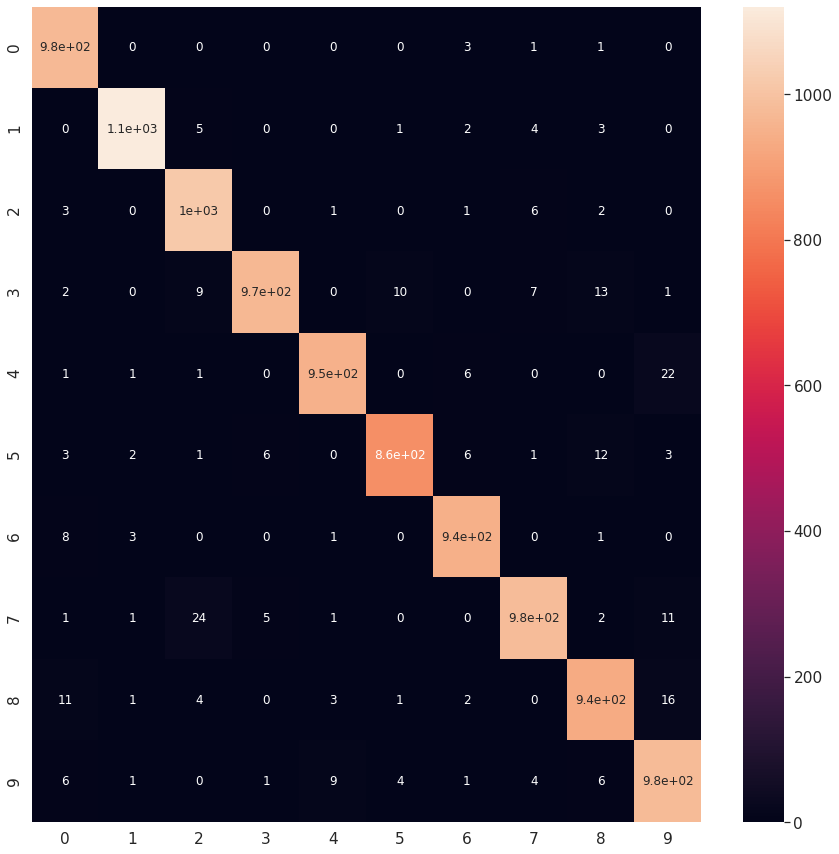

In [19]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


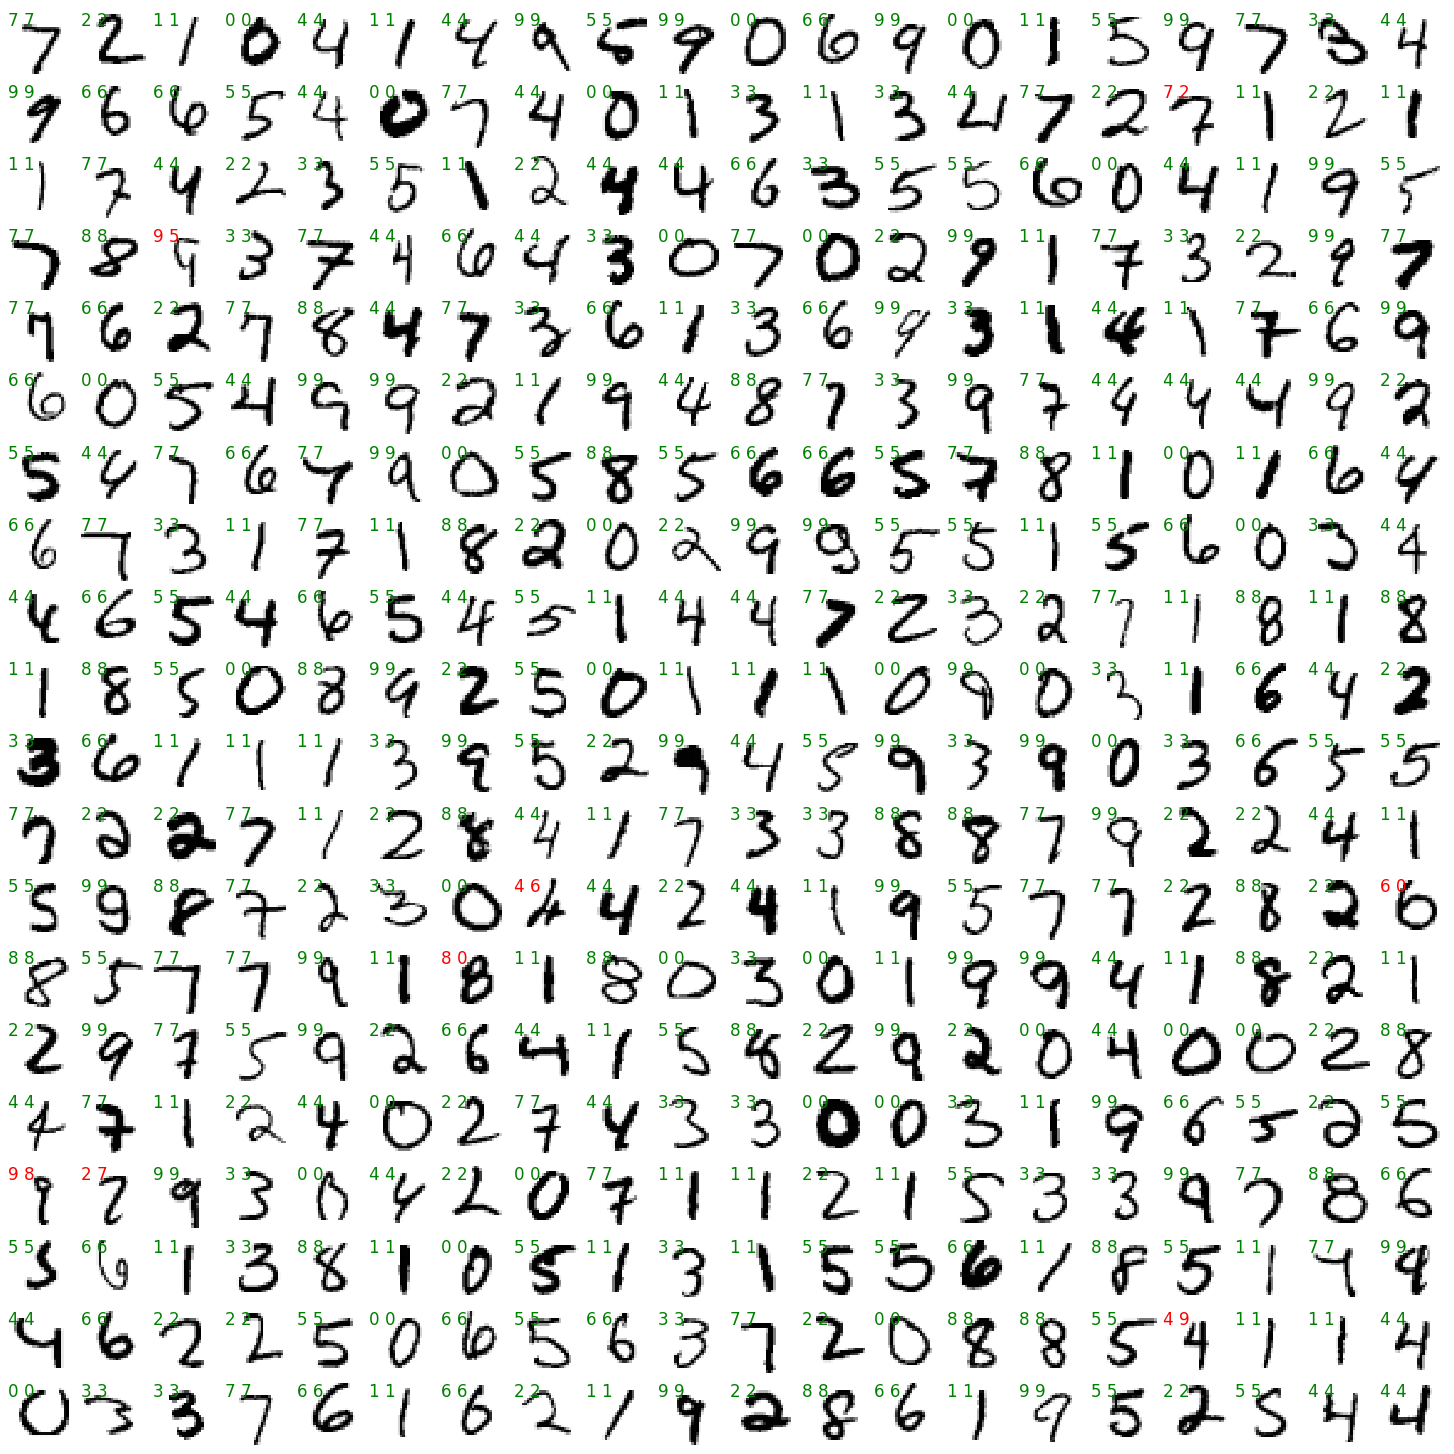

In [20]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

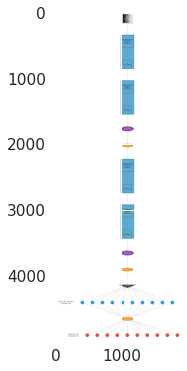

In [21]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()
